In [1]:
import os.path

import matplotlib.pyplot as plt
import matplotlib

import wandb
import pandas as pd
from IPython.core.pylabtools import figsize
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "energy-functions-only"  # e.g., your project name
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)

In [4]:
metric = "eval/episode_success_any"
metric_label = "Success rate"
window_size = 10  # for smoothing the results
env = "ant_u_maze"
env_title_mapping = {
    "ant_ball": "Ant Ball",
    "ant": "Ant",
    "ant_big_maze": "Ant Big Maze",
    "ant_u_maze": "Ant U-Maze",
}
plot_legend= True if env=="ant" else False


In [5]:
exp_names = [
    "ant_l_symmetric_infonce_ef_l1",
    "ant_l_symmetric_infonce_ef_l2",
    "ant_l_symmetric_infonce_ef_l2_no_sqrt",
    "ant_l_symmetric_infonce_ef_dot",
    "ant_l_symmetric_infonce_ef_cos",
]

exp_names_mapping = {
    "ant_l_symmetric_infonce_ef_l1": "L1",
    "ant_l_symmetric_infonce_ef_l2": "L2",
    "ant_l_symmetric_infonce_ef_l2_no_sqrt": "L2 w/o sqrt",
    "ant_l_symmetric_infonce_ef_dot": "Dot",
    "ant_l_symmetric_infonce_ef_cos": "Cos",
}

In [6]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    # "config.n_hidden": 2,
    # "config.h_dim": 256,
    # "config.use_ln": True,
    "config.env_name": env,
    "config.exp_name": {"$in": exp_names},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [7]:
len(runs)

39

In [8]:
# Function to extract metrics from runs
def extract_run_data(run):
    # Extract run config and metrics
    config = run.config
    summary = run.summary._json_dict
    # TODO: potentially just load csv
    if os.path.exists(f"./data/history_{run.id}.csv"):
        history = pd.read_csv(f"./data/history_{run.id}.csv")
    else:
        history = run.history(pandas=True)
        if history.shape[0]!=50:
            raise Exception(f"History shape[0] is not 50. history.shape=={history.shape}")
        history.to_csv(f"./data/history_{run.id}.csv", index=False)
    # Combine run information into a single dictionary

    run_data = {
        "run_id": run.id,
        "name": run.name,
        **config,
        **summary
    }
    return run_data, history

def create_rliable_compatible_data(df, metric):
    return df[metric].to_numpy()

def moving_average_smoothing(data, window_size=3):
    """Apply a moving average filter to the last axis of the input data, ensuring no wrap-around."""
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')
    smoothed = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    return smoothed

In [9]:
# Loop through the runs and collect data
all_histories = []

for run in runs:
    run_data, history = extract_run_data(run)
    all_histories.append(history)

In [10]:
data = {exp_names_mapping[elem]:[] for elem in exp_names}
seeds = {exp_names_mapping[elem]: [] for elem in exp_names}
for run, history in zip(runs, all_histories):
    a = create_rliable_compatible_data(history, metric)
    if run.config["seed"] not in seeds[exp_names_mapping[run.config["exp_name"]]]:
        data[exp_names_mapping[run.config["exp_name"]]].append(a)
        seeds[exp_names_mapping[run.config["exp_name"]]].append(run.config["seed"])

In [11]:
data = {key: np.array(elem)[:,None,:] for key, elem in data.items()}

In [12]:
# TODO: same shapes assert
for exp_name in exp_names:
    print(data[exp_names_mapping[exp_name]].shape)

(5, 1, 50)
(10, 1, 50)
(5, 1, 50)
(10, 1, 50)
(9, 1, 50)


In [13]:
for key, item in data.items():
    data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 


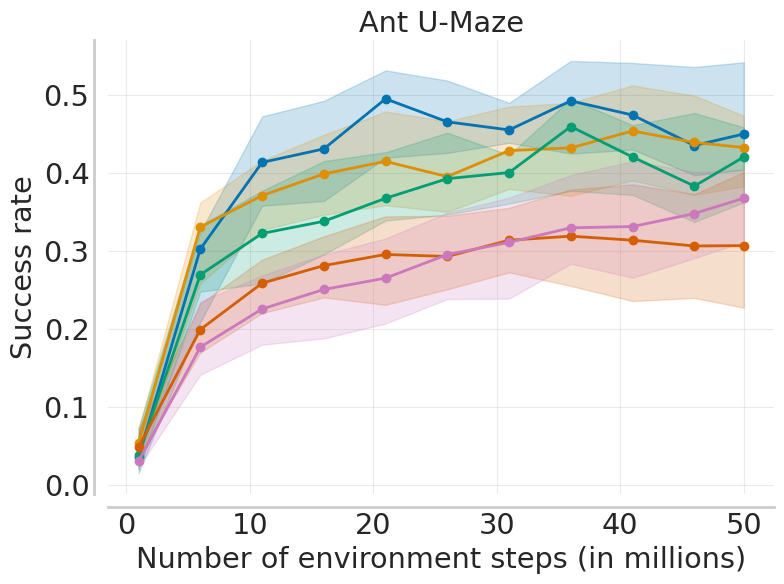

In [23]:
frames = np.arange(0, 55, 5)
frames[-1] -=1
ale_frames_scores_dict = {
    algorithm: score[:, :, frames]
    for algorithm, score in data.items()
}
iqm = lambda scores: np.array(
    [metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])]
)
iqm_scores, iqm_cis = rly.get_interval_estimates(
    ale_frames_scores_dict, iqm, reps=500
)
plot_utils.plot_sample_efficiency_curve(
    frames + 1,
    iqm_scores,
    iqm_cis,
    algorithms=list(data.keys()),
    xlabel=r"Number of environment steps (in millions)",
    ylabel=metric_label,
    legend=plot_legend,
    grid_alpha=0.4,
    figsize=(8,6)
)
plt.title(f"{env_title_mapping[env]}", fontsize="xx-large")
plt.tight_layout()
plt.savefig(os.path.join(figures_path, f"{metric_label}_{env}.png"))

In [25]:
history.shape

(50, 33)